## Environment

In [231]:
#Using latest version of LangChain
import langchain
langchain.__version__

'0.3.17'

### Install Packages

In [232]:
# !pip install langchain_community tiktoken langchain-groq langchainhub chromadb langchain
# !pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

### API Keys

In [233]:
# !pip install dotenv
# !pip install langchain_chroma
# !pip install langchain_huggingface
# !pip install langchain_groq

In [234]:
import os, json, re, getpass
from dotenv import load_dotenv

load_dotenv(".env", override=True)

False

In [235]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [236]:
#Check for Groq API Key
_set_env("GROQ_API_KEY")

In [237]:
#Check for Tavily API Key
_set_env("TAVILY_API_KEY")

### Libraries

In [238]:
# !pip install langchain_community

In [239]:
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pydantic import BaseModel, Field

from pprint import pprint

## Selecting Components

### Chat Model

In [240]:
llm = ChatGroq(model="llama-3.1-8b-instant") #llama3-8b-8192, llama-3.1-8b-instant, llama3-groq-8b-8192-tool-use-preview, llama3-groq-70b-8192-tool-use-preview

### Embedding Model

In [241]:
!pip install tiktoken

In [242]:
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

### Vector Store

In [243]:
vector_store = Chroma(embedding_function=embed_model)

## Retriever

First, we index 3 pages.

In [244]:
urls = [
    "https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science",
    "https://www.jioinstitute.edu.in/academics/study-abroad",
    "https://www.jioinstitute.edu.in/experiential-learning"
]

In [245]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [246]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [247]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embed_model,
)

In [248]:
retriever = vectorstore.as_retriever()

## Define Test Questions

In [249]:
question_search = "Who is Nikola Tesla"

In [250]:
question_doc = "What are the highlights of the PGP in Data Science and AI course at Jio Institute"

## LLMs

### Router

In [251]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

In [252]:
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

In [253]:
# LLM with function call
structured_llm_router = llm.with_structured_output(RouteQuery)

In [312]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [255]:
question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": question_search}
    )
)
print(question_router.invoke({"question": question_doc}))

datasource='web_search'
datasource='web_search'


### Retrieval Grader

In [256]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [257]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [258]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [259]:
retrieval_grader = grade_prompt | structured_llm_grader
docs = retriever.invoke(question_doc)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question_doc, "document": doc_txt}))

binary_score='yes'


In [260]:
docs

[Document(id='5acb44a7-8d77-4906-a1c2-a17135f81565', metadata={'description': "Explore Jio Institute's artificial intelligence course offerings. Dive into the world of AI and data science with our cutting-edge programmes. Apply now!", 'language': 'en', 'source': 'https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science', 'title': 'PGP in Artificial Intelligence & Data Science - Jio Institute'}, page_content='Jio Institute has formulated a seamless digital admissions process to apply to its academic programmes. We invite applications from meritorious students from accross the globe. Eligibility for PGP in Artificial Intelligence & Data Science :A four-year undergraduate degree or its equivalent, in the field of Engineering/Science/ Mathematics and Statistics with minimum 50 per cent or equivalent CGPA. A postgraduate degree (if the undergraduate degree is of three years) in the field of'),
 Document(id='6e39b860-3f9f-4db7-8c78-055b47268977', metadata={'description'

### Generate

In [261]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [262]:
# Prompt
prompt = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [263]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [264]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [265]:
# Chain
rag_chain = prompt | llm | StrOutputParser()

In [266]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question_doc})
print(generation)

Unfortunately, the provided context does not mention the highlights of the PGP in Data Science and AI course at Jio Institute.


### Hallucination Grader

In [267]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [268]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [269]:
# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

In [270]:
hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='no')

In [271]:
docs

[Document(id='5acb44a7-8d77-4906-a1c2-a17135f81565', metadata={'description': "Explore Jio Institute's artificial intelligence course offerings. Dive into the world of AI and data science with our cutting-edge programmes. Apply now!", 'language': 'en', 'source': 'https://www.jioinstitute.edu.in/academics/artificial-intelligence-data-science', 'title': 'PGP in Artificial Intelligence & Data Science - Jio Institute'}, page_content='Jio Institute has formulated a seamless digital admissions process to apply to its academic programmes. We invite applications from meritorious students from accross the globe. Eligibility for PGP in Artificial Intelligence & Data Science :A four-year undergraduate degree or its equivalent, in the field of Engineering/Science/ Mathematics and Statistics with minimum 50 per cent or equivalent CGPA. A postgraduate degree (if the undergraduate degree is of three years) in the field of'),
 Document(id='6e39b860-3f9f-4db7-8c78-055b47268977', metadata={'description'

In [272]:
generation

'Unfortunately, the provided context does not mention the highlights of the PGP in Data Science and AI course at Jio Institute.'

### Answer Grader

In [273]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [274]:
# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeAnswer)

In [275]:
# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

In [276]:
answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question_doc, "generation": generation})

GradeAnswer(binary_score='no')

In [277]:
print(question_doc, "\n\n", generation)

What are the highlights of the PGP in Data Science and AI course at Jio Institute 

 Unfortunately, the provided context does not mention the highlights of the PGP in Data Science and AI course at Jio Institute.


### Question Re-writer

In [278]:
# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n
     Only return the rewritten question and nothing else."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

In [279]:
question_doc

'What are the highlights of the PGP in Data Science and AI course at Jio Institute'

In [280]:
question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question_doc})

'What is the course details and key takeaways of PGP in Data Science and AI at Jio Institute?'

## Tools

### Search Tool

In [281]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## Construct the Graph

Capture the flow in as a graph.

### Define Graph State

We will define a graph.

A `state` object that it passes around to each node.

Our state will have 3 attributes - `question`, `generation` and `documents`.

Each node in our graph will update to it.

In [282]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### Define Graph Flow

We can lay out an agentic RAG graph like this:

* The state has a set of attributes
* Each node will update the state
* Conditional edges decide which node to visit next

#### Nodes

In [283]:
from langchain.schema import Document

In [284]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [285]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [286]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

In [287]:
question_rewriter

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a question re-writer that converts an input question to a better version that is optimized \n \n     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n \n     Only return the rewritten question and nothing else.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='Here is the initial question: \n\n {question} \n Formulate an improved question.'), additional_kwargs={})])
| ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ba7d814ce50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ba7d80e8150>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_

In [288]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [289]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    #Condition for Adaptive RAG, that has a flow of web search without a retrieval step first
    if "documents" in state.keys():
        documents = state["documents"]
        documents.append(web_results)
        return {"documents": documents, "question": question}

    else:
        return {"documents": web_results, "question": question}

#### Edges

In [290]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    # return source.datasource

    if source.datasource == "wikipedia":
        print("---ROUTE QUESTION TO WIKIPEDIA---")
        return "wikipedia"
    elif source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [291]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [292]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Compile Graph

All these flows are different kinds of **Self-Reflective RAG**, and Adaptive RAG has an additional flow of **Query Analysis**.

#### Flow 1 - Corrective RAG

![image.png](attachment:154f6f10-663f-4395-ae9d-ce17ffbac87b.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/)

In [293]:
# !pip install langgraph

In [294]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
graph_1_crag = workflow.compile()

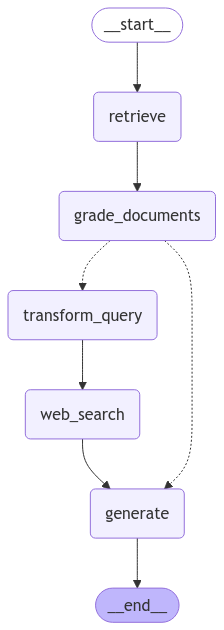

In [295]:
from IPython.display import Image, display

try:
    display(Image(graph_1_crag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 2 - Self-RAG

![image.png](attachment:fef27379-03c6-4085-826f-33d3c2070557.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_self_rag/)

In [296]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_2_selfrag = workflow.compile()

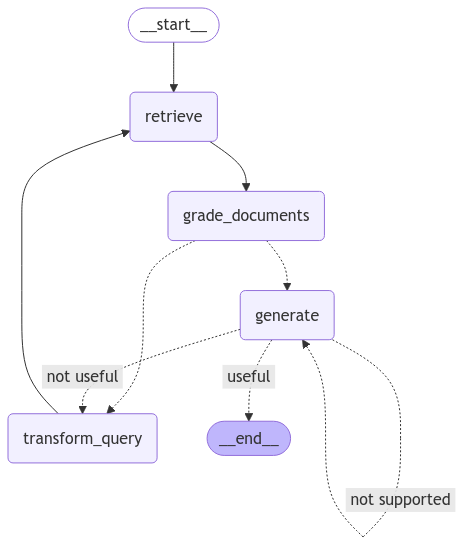

In [297]:
from IPython.display import Image, display

try:
    display(Image(graph_2_selfrag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 3 - Corrective RAG (custom) = Corrective RAG + Hallucination + Answer Relevance Checker

In [298]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_3_crag_custom = workflow.compile()

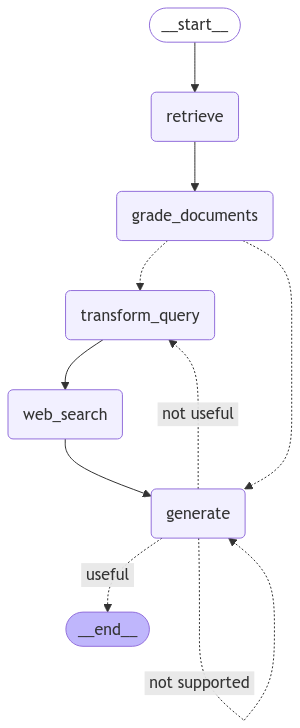

In [299]:
from IPython.display import Image, display

try:
    display(Image(graph_3_crag_custom.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 4 - Adaptive RAG = Self-RAG + Query Analysis

![image.png](attachment:9079738e-a1ed-4534-bf04-f8d48817dd14.png)
[Reference here](https://python.langchain.com/v0.1/docs/use_cases/query_analysis/)

![image.png](attachment:667874de-699e-4766-b8d9-66da8ac82645.png)
[Reference here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/)

In [300]:
# !pip install wikipedia

In [301]:
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langgraph.graph import END, StateGraph, START

# Initialize Wikipedia tool
wiki_api_wrapper = WikipediaAPIWrapper()
wikipedia_tool = WikipediaQueryRun(api_wrapper=wiki_api_wrapper)

# 🚀 **Recreate the Workflow from Scratch**
workflow = StateGraph(GraphState)

# Define the nodes again
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

# ✅ **Add Wikipedia node**
workflow.add_node("wikipedia_search", lambda x: wikipedia_tool.run(x["query"]))

# ✅ **Re-add routing with Wikipedia included**
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "wikipedia": "wikipedia_search",  # New Wikipedia path
    },
)

# ✅ **Ensure Wikipedia search leads to END**
workflow.add_edge("wikipedia_search", END)  # Stops after Wikipedia search

# Other paths
workflow.add_edge("web_search", "generate")  # Web search routes to generation
workflow.add_edge("retrieve", "grade_documents")  # Retrieval to grading

# ✅ **Fix: Ensure Generation Can End**
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

workflow.add_edge("transform_query", "retrieve")  # Transform query loops back to retrieval

# ✅ **Ensure "generate" has a stopping condition**
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": END,  # 🚀 Fix: Ensure a path leads to END
        "useful": END,  # 🚀 Fix: Ensure a path leads to END
        "not useful": "transform_query",
    },
)

# ✅ **Compile the workflow again**
graph_4_adaptiverag = workflow.compile()


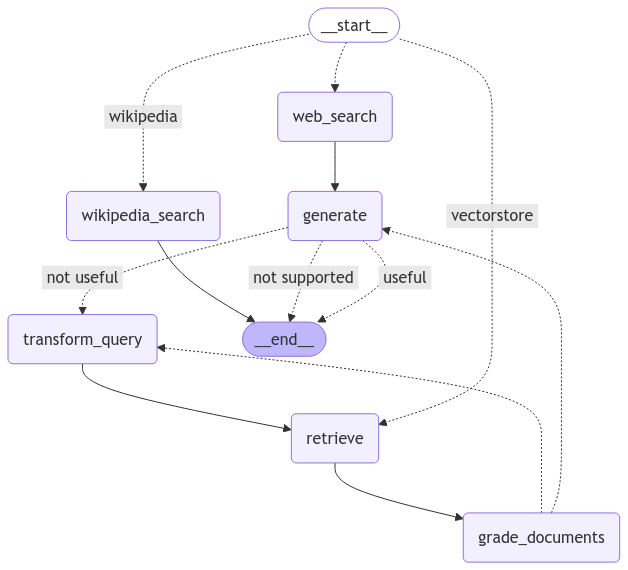

In [302]:
from IPython.display import Image, display

try:
    display(Image(graph_4_adaptiverag.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Flow 5 - Adaptive RAG (custom) = Corrective RAG (custom) + Query Analysis

In [303]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
# set_conditional_entry_point method doesn't require mentioning START
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
graph_5_adaptiverag_custom = workflow.compile()

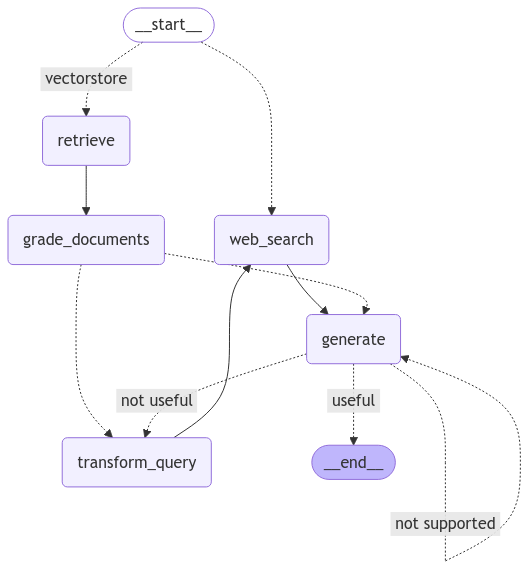

In [304]:
from IPython.display import Image, display

try:
    display(Image(graph_5_adaptiverag_custom.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use Graph

### For Question Not in Context

In [305]:
question_search

'Who is Nikola Tesla'

In [306]:
# Run
inputs = {
    "question": question_search
}

In [307]:
#Self-RAG gets stuck in loop!
for i,app in enumerate([graph_1_crag, graph_3_crag_custom, graph_5_adaptiverag_custom]):
    print("FLOW {}----->".format(str(2*i+1))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")

FLOW 1----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Nikola Tesla was born on July 10, 1856, in Smiljan, Croatia. He studied at '
 'the Realschule in Karlstadt, Germany, the Polytechnic Institute in Graz, '
 'Austria, and the University of Prague in the 1870s. Tesla immigrated to the '
 'United States in 1884.')
------------------------------------------------------------



FLOW 3----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---G

### For Question in Context

In [308]:
question_doc

'What are the highlights of the PGP in Data Science and AI course at Jio Institute'

In [309]:
# Run
inputs = {"question": question_doc}

In [314]:
for i,app in enumerate([graph_1_crag, graph_2_selfrag, graph_3_crag_custom]):
    print("FLOW {}----->".format(str(i+1))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")

FLOW 1----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('The PGP in Data Science and AI course at Jio Institute has a comprehensive '
 'and rigorous curriculum that covers foundation and advanced courses to train '
 'future-ready full-stack data scientists and AI architects. The course is '
 'designed for students with a four-year undergraduate degree or its '
 'equivalent in Engineering/Science/Mathematics and Statistics. The '
 'eligibility criteria also include a postgraduate degree for students with a '
 'three-year undergraduate degree.')
------------------------------------------------------------



FLOW 2----->

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEV

In [313]:
#Adaptive RAG (custom) is referring to web search, although information is present in the provided context
for i,app in enumerate([graph_4_adaptiverag, graph_5_adaptiverag_custom]):
    print("FLOW {}----->".format(str(i+4))+"\n")
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])
    print("---"*20 + "\n\n\n")

FLOW 4----->

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
'---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---'
"Node 'generate':"
'\n---\n'
('Unfortunately, the provided context does not explicitly mention the '
 'highlights of the PGP in Data Science and AI course at Jio Institute. The '
 'context only provides information on the eligibility criteria for the '
 'course.')
------------------------------------------------------------



FLOW 5----->

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
'---DECISION: GENERATION IS NOT GROUND

In [327]:
# STEP 9 - Test with a relevant question that routes to Wikipedia

# Define test queries (all should go to Wikipedia)
test_queries = [
    "Who is Nikola Tesla?",
    "History of Artificial Intelligence",
    "Define Reinforcement Learning",
    "What is Quantum Computing?",
]

# Function to test Wikipedia routing
def test_wikipedia_routing(query):
    print(f"\n🚀 Testing query: {query}")
    state = {"question": query}
    selected_tool = route_question(state)  # Determine which tool it goes to

    # Ensure it's routing to Wikipedia
    if selected_tool == "wikipedia":
        print(f"✅ Routed to: WIKIPEDIA")
        result = wikipedia_tool.run(query)  # Execute Wikipedia tool
        print(f"📌 Wikipedia Result: {result[:500]}")  # Show first 500 characters
    else:
        print(f"❌ Incorrect Routing! Expected Wikipedia but got: {selected_tool}")

# Run the test cases
for query in test_queries:
    test_wikipedia_routing(query)



🚀 Testing query: Who is Nikola Tesla?
---ROUTE QUESTION---
🔍 Raw Output from question_router: {'question': 'Who is Nikola Tesla?', 'text': 'The best tool for the query "Who is Nikola Tesla" would be \'wikipedia\'. \n\nNikola Tesla is a historical figure, an inventor, and a pioneer in the field of electrical engineering. Wikipedia would provide a comprehensive overview of his life, work, and contributions to the field of electrical engineering, making it the most suitable source for this type of query.'}
---ROUTE QUESTION TO WIKIPEDIA---
✅ Routed to: WIKIPEDIA
📌 Wikipedia Result: Page: Nikola Tesla's Night of Terror
Summary: "Nikola Tesla's Night of Terror" is the fourth episode of the twelfth series of the British science fiction television programme Doctor Who, first broadcast on BBC One on 19 January 2020. It was written by Nina Metivier, and directed by Nida Manzoor.
In 1903, the Thirteenth Doctor (Jodie Whittaker) helps Nikola Tesla (Goran Višnjić) escape from being kidnapped by t

In [329]:
# !pip install langsmith

In [337]:
import os

# ✅ Set LangSmith API Key
os.environ["LANGCHAIN_API_KEY"] = "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"  # Replace with actual API Key

# ✅ Enable LangSmith Tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# ✅ Ensure LangChain sends traces to LangSmith
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "MyLangSmithProject"  # Change this to a project name


In [330]:
#Check for LangSmith tracing
_set_env("LANGCHAIN_TRACING_V2")

LANGCHAIN_TRACING_V2: ··········


In [331]:
#Check for LangChain API Key - LangSmith
_set_env("LANGCHAIN_API_KEY")

LANGCHAIN_API_KEY: ··········


In [338]:
from langsmith import trace

# Define the query (same for all three runs)
test_query = "Who is Nikola Tesla?"

# Function to run the query and collect trace data
def run_wikipedia_query(query):
    with trace(name="Wikipedia Query Trace"):
        print(f"\n🚀 Running Wikipedia Query: {query}")

        state = {"question": query}
        selected_tool = route_question(state)

        if selected_tool == "wikipedia":
            print(f"✅ Routed to: WIKIPEDIA")
            result = wikipedia_tool.run(query)
            print(f"📌 Wikipedia Result: {result[:500]}")  # Show first 500 characters
        else:
            print(f"❌ Incorrect Routing! Expected Wikipedia but got: {selected_tool}")
            result = None

        return result

# ✅ Run the query 3 times to generate 3 traces
for i in range(3):
    run_wikipedia_query(test_query)



🚀 Running Wikipedia Query: Who is Nikola Tesla?
---ROUTE QUESTION---
🔍 Raw Output from question_router: {'question': 'Who is Nikola Tesla?', 'text': 'For the query "Who is Nikola Tesla", I would recommend using the tool \'wikipedia\'. \n\nNikola Tesla is a historical figure, and his information is readily available on Wikipedia. This platform would provide a detailed biography, historical context, and general knowledge about his life and contributions.'}
---ROUTE QUESTION TO WIKIPEDIA---
✅ Routed to: WIKIPEDIA
📌 Wikipedia Result: Page: Nikola Tesla's Night of Terror
Summary: "Nikola Tesla's Night of Terror" is the fourth episode of the twelfth series of the British science fiction television programme Doctor Who, first broadcast on BBC One on 19 January 2020. It was written by Nina Metivier, and directed by Nida Manzoor.
In 1903, the Thirteenth Doctor (Jodie Whittaker) helps Nikola Tesla (Goran Višnjić) escape from being kidnapped by the Skithra aliens, along with the assistance of he